In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule

from qiskit.tools.monitor import job_monitor

from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

backend_defaults = backend.defaults()

backend_properties = backend.properties()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7
x_duration = 320
x_sigma = 80
f01 = 4924993522.1397295
x01_amp = 0.08653102211831362

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            # result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
            result_data.append(np.real(job_results.get_memory(i)[0] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(np.linspace(x_values[0], x_values[-1], 10000), *fitparams)
    
    return fitparams, y_fit

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Qubit 0 has an estimated frequency of 4.925038309664436 GHz.
Default anharmonicity is -0.3443958771022938 GHz.


# 12 calibration

## Frequency sweep

In [13]:
# smaller range sweep
num_freqs = 75
drive_power = 0.15
sweep_range = 15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-sweep_range*MHz, sweep_range*MHz, num_freqs)

In [14]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as X01_Gaussian_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)

In [15]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x_duration,
                                  amp=drive_power,
                                  sigma=x_sigma,
                                  name='x12_pulse'), drive_chan)

In [16]:
spect_gate = Gate("spect", 1, [freq])
X01_Gaussian = Gate("$X_{\pi}^{01}$", 1, [])

qc_spect = QuantumCircuit(qubit + 1, 1)
qc_spect.append(X01_Gaussian, [qubit])
# qc_spect.x(qubit)
qc_spect.append(spect_gate, [qubit])
qc_spect.measure(qubit, 0)
qc_spect.add_calibration(spect_gate, (qubit,), freq12_sweep_sched, [freq])
qc_spect.add_calibration(X01_Gaussian, (qubit,), X01_Gaussian_sched, [])

exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

In [17]:
NUM_SHOTS = 20000
excited_freq_sweep_job = backend.run(exp_spect_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=NUM_SHOTS)
excited_freq_sweep_job.job_id()

'6364b2fc754e4643234cca77'

## Job id 
02/11/22: 6361d5d0ad241417a710e190 
6361ef64aa69d0974e09480d drive_power = 0.05, range = 30
04/11/22: 636489afe0f7304cbb9bd09c drive_power = 0.15, range = 30
          6364942ce0f73029189bd0b9 range = 1.5
          6364b2fc754e4643234cca77 range = 15

In [73]:
excited_freq_sweep_job = backend.retrieve_job('6364b2fc754e4643234cca77')

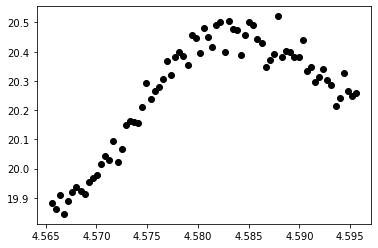

In [74]:
# Get the refined data (average)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_sweep_freqs = f01 + sweep_freqs
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')

In [76]:
# do fit in Hz
(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [20, 4.58*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

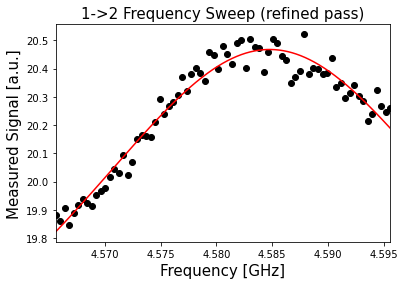

In [78]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(np.linspace(excited_sweep_freqs[0]/GHz, excited_sweep_freqs[-1]/GHz, 10000), excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [79]:
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.5847749 GHz.


## Rabi 12

In [3]:
f12 = default_qubit_freq + default_anharmonicity*GHz
f12

4580642432.562142

In [4]:
# experimental configuration
num_rabi_points = 100 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 0.4
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [5]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=x_duration,
                              amp=amp,
                              sigma=x_sigma,
                              name='x12_pulse'), drive_chan)

In [6]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as X01_Gaussian_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)

In [7]:
rabi_gate = Gate("rabi", 1, [amp])
X01_Gaussian = Gate("$X_{\pi}^{01}$", 1, [])

qc_rabi = QuantumCircuit(qubit + 1, 1)

qc_rabi.append(X01_Gaussian, [qubit])
qc_rabi.append(rabi_gate, [qubit])
qc_rabi.measure(qubit, 0)
qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched, [amp])
qc_rabi.add_calibration(X01_Gaussian, (qubit,), X01_Gaussian_sched, [])    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]


In [8]:
num_shots_per_point = 20000

rabi12_job = backend.run(exp_rabi_circs, 
                          meas_level=1, 
                          meas_return='avg', 
                          shots=NUM_SHOTS)

rabi12_job.job_id()

'636d20bb0565be1b5700764e'

## Rabi 12 job id
04/11/22: 636493c8754e469f424cca41 range = [0, 1]
          6364c039ad2414d52e10eb0a range = [0, 0.4]
10/11/22: '636d20bb0565be1b5700764e' range = [0, 0.4]

In [55]:
rabi12_job = backend.retrieve_job('6364c039ad2414d52e10eb0a')

In [56]:
rabi12_data = get_job_data(rabi12_job, average=True)

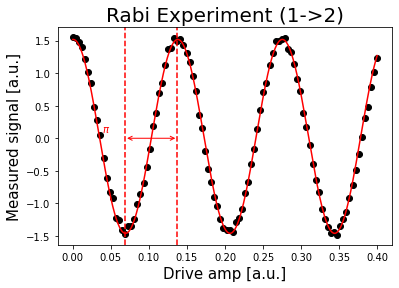

In [57]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi12_data = np.real(baseline_remove(rabi12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                               rabi12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [2, 1, 0.15, 0])

plt.scatter(drive_amps, rabi12_data, color='black')
plt.plot(np.linspace(drive_amps[0], drive_amps[-1], 10000), rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [58]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{f12} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4580649319.495695 GHz.
Pi Amplitude (1->2) = 0.06870562817072146


# Rough Discriminator (using Gaussian pulse)

In [ ]:
f12 = 4580649319.495695
x12_amp = 0.06870562817072146

In [60]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as X01_Gaussian_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)

with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as X12_Gaussian_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=x_duration,
                            amp=x12_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(12)}$'), drive_chan)

In [62]:
# Create the three circuits
X01_Gaussian = Gate("$X_{\pi}^{01}$", 1, [])
X12_Gaussian = Gate("$X_{\pi}^{12}$", 1, [])
# 0 state
qc_g = QuantumCircuit(1, 1)
qc_g.measure(0, 0)

# 1 state
qc_e = QuantumCircuit(1, 1)

qc_e.append(X01_Gaussian, [0])
qc_e.add_calibration(X01_Gaussian, (0,), X01_Gaussian_sched, [])
qc_e.measure(0, 0)

# 2 state 
qc_f = QuantumCircuit(1, 1)
qc_f.append(X01_Gaussian, [0])
qc_f.append(X12_Gaussian, [0])
qc_f.measure(0, 0)
qc_f.add_calibration(X01_Gaussian, (0,), X01_Gaussian_sched, [])
qc_f.add_calibration(X12_Gaussian, (0,), X12_Gaussian_sched, [])

In [63]:
# Assemble the schedules into a program\
NUM_SHOTS = 20000
IQ_012_job = backend.run([qc_g, qc_e, qc_f], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=NUM_SHOTS)
IQ_012_job.job_id()

'6364c464718d11b10862f44c'

job id
04/11/22 6364c1a2ad24146d0a10eb10
         6364c464718d11b10862f44c
         

In [69]:
IQ_012_job = backend.retrieve_job('6364c464718d11b10862f44c')

In [70]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped


# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)


def count(job, discriminator):
    print('retrieving data from', job.job_id())
    data = get_job_data(job, average=False)
    print('data is retrieved from', job.job_id())
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

(60000, 2)
60000


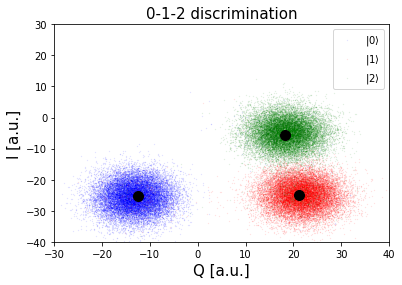

In [71]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    alpha = 0.2
    size = 0.05
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')
x_min = -30
x_max = 40
y_min = -40
y_max = 30
IQ_012_plot(x_min, x_max, y_min, y_max)
# separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)


In [72]:
discr_data = count(IQ_012_job, LDA_012)
#confusion matrix
conf_mat = [[discr_data[i]['0'] / 20000, discr_data[i]['1'] / 20000, discr_data[i]['2'] / 20000] for i in
                   range(np.shape(discr_data)[0])] 
conf_mat

retrieving data from 6364c464718d11b10862f44c
data is retrieved from 6364c464718d11b10862f44c


[[0.9778, 0.0089, 0.0133],
 [0.0108, 0.97835, 0.01085],
 [0.0079, 0.03225, 0.95985]]